In [0]:
import os
import time
import math
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [0]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

## Часть 1

#### Задание 1.1 [6 баллов]

Реализуйте свой класс LogReg - собственная имплементация логистической регрессии с l2 регуляризацией

In [0]:
from sklearn.base import BaseEstimator

In [0]:
class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, gd_type='full', batch_size=None,
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, 
                 verbose=False):
        """
        lambda_2: L2 regularization param value
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.batch_size = None if self.gd_type == 'full' else batch_size
        if self.batch_size is None and self.gd_type != 'full':
            raise Exception('Need to specify batch size!')
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.loss_history = []
        self.w_history = []
        self.grad_norm_history = []
        self.verbose = verbose
        # Могут быть ешё параметры
        

    def sigmoid(self, z):
        """
        Просто вычисляет сигмоиду
        """
        sigm = lambda x: 1 / (1 + math.exp(-x))
        return np.vectorize(sigm)(z)
  
    
    def fit(self, X, y):
        """
        X: np.array of shape (N, d)
        y: np.array of shape (N, 1)
        """
        i = 0; loss = self.tolerance + 10
        self.w = self.w0 if self.w0 is not None else np.random.rand((X.spape[1], 1))     
        while i < self.max_iter and loss > self.tolerance :
            if self.gd_type == "stochastic":
                indexes = np.random.choice(X.shape[0], self.batch_size)
                data, target = X[indexes], y[indexes]
            else:
                data, target = X, y
                
            self.w_history.append(self.w)
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            grad = self.calc_gradient(data, target)
            grad_norm = np.linalg.norm(grad)
            self.grad_norm_history.append(grad_norm)
            
            self.w = self.w - self.alpha*grad
            i += 1
    
    def predict_proba(self, X):
        """
        X: np.array of shape (N, d)
        ---
        output: np.array of shape (N, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        res = sigmoid(X.dot(self.w))
        return [1 - res, res]
    
        
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (N, d) (N is equal to batch_size if gd_type="stochastic")
        y: np.array of shape (N, 1)
        ---
        output: np.array of shape (d, 1)
        """
        res = np.zeros((X.shape[1], 1))
        for i in range(self.w.shape[0]):
            k = 0
            for x in X.dot(self.w):
                res[i][0] += -y[k]*X[k][i]*math.exp(-y[k]*x)/(1 + math.exp(-y[k]*x))
                k += 1
        return res
    
    def calc_loss(self, X, y):
        """
        X: np.array of shape (N, d)
        y: np.array of shape (N, 1)
        ---
        output: float 
        """ 
        loss = 0; k = 0
        for x in X.dot(self.w):
            loss += math.log(1 + math.exp(-y[k]*x[0])) 
            k += 1
        return loss + self.lambda_2*np.linalg.norm(self.w)    


Сгенерируем модельную выборку, для проверки нашего класса

In [0]:
N = 10000
X = np.random.normal(loc=0, scale=4, size=(N))
X = np.hstack((
    np.ones(X.shape[0]).reshape(-1, 1),
    X.reshape(-1, 1)
))
y = (
    2*(3*X[:, 1] + np.random.normal(scale=4, size=N) > 0) - 1
).astype(int).reshape(-1, 1)
w_init = np.random.randint(-10, 10, size=(2, 1))

Разделите данные на обучение и контроль

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#### Задание 1.2 [3 балла]

Обучите Вашу реализацию логрега на обучающей выборке и протестируйте качество на котрольной выборке. Нарисуйте графики лосса в зависимости от числа итераций для обучения для полного градиентного спуска, а так же для стохастического градиентного спуска c различной величиной батча (батч размера 1, 10, 20, 30, половина выборки, вся выборка) 

gd_type = full  loss =  705.1287335761349
batch size =  1 loss =  37569.00802318257
batch size =  10 loss =  30062.777026139076
batch size =  20 loss =  22330.594669960192
batch size =  30 loss =  13698.029533645025


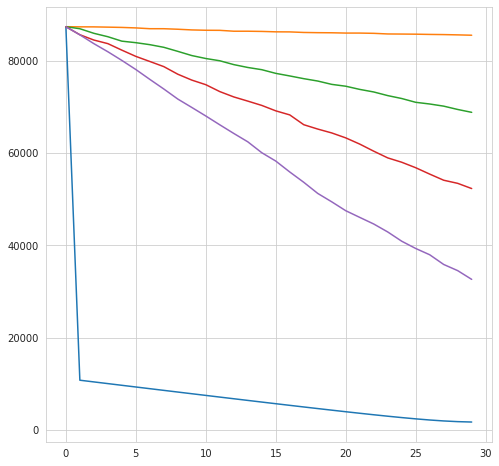

In [0]:
# Ваш код здесь:
lr = LogReg(lambda_2 = 0., gd_type='full', batch_size=None,
            tolerance=1e-4, max_iter=30, w0=w_init, alpha=1e-3, 
                 verbose=False)
lr.fit(X_train, y_train)
plt.plot(lr.loss_history)
print("gd_type = full ", "loss = ", lr.calc_loss(X_test, y_test))


lr.gd_type = "stochastic"
bs = [1, 10, 20, 30]
for i in range(4):
    lr.loss_history = []
    lr.batch_size = bs[i]
    lr.fit(X_train, y_train)
    plt.plot(lr.loss_history)
    print('batch size = ', bs[i], 'loss = ', lr.calc_loss(X_test, y_test))
    
plt.show()

## Часть 2
## Word2Vec

В этой части задания Вам необходимо будет реализовать алгоритм поиска эмбеддингов для слов Word2Vec (модификация SkipGramNS)

Загрузите лемматизированные тексты lemm_wiki_texts.txt для обучения

In [0]:
!wget -O lemm_wiki_texts.txt https://www.dropbox.com/s/wfh403us223yjuf/lemm_wiki_texts.txt?dl=0

--2019-12-27 22:42:21--  https://www.dropbox.com/s/wfh403us223yjuf/lemm_wiki_texts.txt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wfh403us223yjuf/lemm_wiki_texts.txt [following]
--2019-12-27 22:42:21--  https://www.dropbox.com/s/raw/wfh403us223yjuf/lemm_wiki_texts.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0b9f56a799beed6cf7b9e61fc6.dl.dropboxusercontent.com/cd/0/inline/AvAF8czYZ-xi9ilwv67OfOL4TMKZNbs7b6jb4N96EIf9Yiww5rsKUEhOmYWsiA89hV0QVscO1iMz0RJrSftb9SI43tIJ_FDQd6t2AbmHBc0dPhCt_OAaj9GTNNRRrVK0TZw/file# [following]
--2019-12-27 22:42:22--  https://uc0b9f56a799beed6cf7b9e61fc6.dl.dropboxusercontent.com/cd/0/inline/AvAF8czYZ-xi9ilwv67OfOL4TMKZNbs7b6jb4N96EIf9Yiww5rsKUEhOmYWsiA89hV0QVscO1iMz0RJrSftb9SI4

In [0]:
# Загрузка текстов
with open('lemm_wiki_texts.txt', mode='r', encoding='utf-8') as f:
    lemm_wiki_texts = f.readlines()

In [0]:
# у вас должно получиться 1095910 текстов - проверьте
# Ваш код здесь:
len(lemm_wiki_texts)

1095910

#### Задание 2.0 [1 балл]

Реализуйте функцию, которая принимает на вход список текстов (такой например, как lemm_wiki_texts) и выдаёт список списков, где каждый внутренний список содержит 3 элемента: 2 слов и 1 число (0 или 1), символизирующее, находится ли пара слов в одном контексте, или нет.

In [0]:
def prepare_text_for_skipgramns(texts: list, context_width: int=5, negative_samples: int=10) -> list:
    """
    texts: список текстов, по которому необходимо будет составить итоговый список
    context_width: ширина окна. Слова, находящиеся в одном окне считаются из одного контекста
    negative_samples: сколько негативных примеров генерировать на каждый положительный пример.
    return: resulting_list: Пример: [
    ["мама", "готовит", 1],
    ['мама', "океан", 0],
    ["надёжный", "подрядчик", 1],
    ["надёжный", "мороженое", 0],
    ...
    ]
    """
    k = 0
    resulting_list = []
    for text in texts:
      txt = text.split(' ')
      for i in range(len(txt)):
        #for j in range(max(0, i - context_width), min(len(txt), i + context_width)):
        for j in range(len(txt)):
          if j == i:
            continue
          if abs(i - j) < context_width:
            resulting_list.append([txt[i], txt[j], 1])
      print(k, len(texts)); k+=1
    return resulting_list

#### Задание 2.1 [15 баллов]

Реализуйте класс, который будет использоваться для обучения Word2Vec векторов. Реализовывать можно как на голом numpy, так и с помощью вспомогательных библиотек. Рекомендуется освоить библиотеку, [pytorch](https://pytorch.org/). Во-первых, она будет в дальнейшем использоваться, при прохождении нейросетей, а во-вторых, есть видео, которое шаг за шагом позволяет реализовать Word2Vec алгоритм на pytorch:
https://stepik.org/lesson/247966/step/1?unit=220078 (P.S. Можно просто реализовать Word2Vec точно так же, как на видео)

У этого класса обязательно должен быть метод, который "обучает" эмбеддинги. Результатом обучения должен быть словарь (dict), ключами которого являются слова, а значениями - эмбеддинги этих слов

In [0]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git
import sys; sys.path.append('/content/stepik-dl-nlp')
!pip3 install spacy_udpipe

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 213 (delta 8), reused 19 (delta 5), pack-reused 190
Receiving objects: 100% (213/213), 42.11 MiB | 21.07 MiB/s, done.
Resolving deltas: 100% (87/87), done.
     |████████████████████████████████| 307kB 7.0MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625768 sha256=7ce854c1bc4ab56a1debfdb498167b1b3d84e0487d616ed597ee0e4344de2ed5
  Stored in directory: /root/.cache/pip/wheels/0c/9d/db/6d3404c33da5b7adb6c6972853efb6a27649d3ba15f7e9bebb
Successfully built ufal.udpipe


In [0]:
import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

class word2vec:
  def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
    self.trainer = SkipGramNegativeSamplingTrainer(vocab_size, emb_size, sentence_len, radius, negative_samples_n)

  class SkipGramNegativeSamplingTrainer(nn.Module):
      def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
          super().__init__()
          self.vocab_size = vocab_size
          self.negative_samples_n = negative_samples_n

          self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
          self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
          self.center_emb.weight.data[0] = 0

          self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
          self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
          self.context_emb.weight.data[0] = 0

          self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
      def forward(self, sentences):
          """sentences - Batch x MaxSentLength - идентификаторы токенов"""
          batch_size = sentences.shape[0]
          center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

          positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
          positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
          positive_probs = torch.sigmoid(positive_sims)

          positive_mask = self.positive_sim_mask.to(positive_sims.device)
          positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                                 positive_mask.expand_as(positive_probs))

          negative_words = torch.randint(1, self.vocab_size,
                                         size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
          negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
          negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN

          negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

          return positive_loss + negative_loss

  def train(self, train_dataset, test_dataset, lr = 1e-2, epoch_n=2, batch_size = 8, device='cpu'):
    train_eval_loop(self.trainer(), 
                    train_dataset,
                    test_dataset,
                    no_loss,
                    lr=lr,
                    epoch_n = epoch_n,
                    batch_size = batch_size,
                    device=device,
                    early_stopping_patience=early_stopping_patience,
                    max_batches_per_epoch_train=max_batches_per_epoch_train,
                    max_batches_per_epoch_val=len(test_dataset),
                    lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True)
                    ) 
    return self.trainer

def no_loss(pred, target):
    return pred

#### Задание 2.2 [5 баллов]

Создайте класс, для удобного обращения с обученными векторами

In [0]:
class Embeddings:
    def __init__(self, embeddings, word2id):
        self.embeddings = embeddings
        self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4)
        self.word2id = word2id
        self.id2word = {i: w for w, i in word2id.items()}

    def most_similar(self, word, topk=10):
        return self.most_similar_by_vector(self.get_vector(word), topk=topk)

    def analogy(self, a1, b1, a2, topk=10):
        a1_v = self.get_vector(a1)
        b1_v = self.get_vector(b1)
        a2_v = self.get_vector(a2)
        query = b1_v - a1_v + a2_v
        return self.most_similar_by_vector(query, topk=topk)

    def most_similar_by_vector(self, query_vector, topk=10):
        similarities = (self.embeddings * query_vector).sum(-1)
        best_indices = np.argpartition(-similarities, topk, axis=0)[:topk]
        result = [(self.id2word[i], similarities[i]) for i in best_indices]
        result.sort(key=lambda pair: -pair[1])
        return result

    def get_vector(self, word):
        if word not in self.word2id:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embeddings[self.word2id[word]]

    def get_vectors(self, *words):
        word_ids = [self.word2id[i] for i in words]
        vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
        return vectors

Найдите несколько интересных аналогий в словах (что-то типо: король-мужчина+женщина=королева)

#### Задание 3.4 [3 балла]
#### Обучение из коробки

Обучите Word2Vec "из коробки" с помощью библиотеки [gensim](https://radimrehurek.com/gensim/)

In [0]:
from gensim.models import Word2Vec
texts = list(map(lambda x: x.split(' '), lemm_wiki_texts[:10000]))
model = Word2Vec(window = 3, size= 50, negative = 5, workers=10)
model.build_vocab(texts, progress_per=100)
model.train(texts, total_examples = model.corpus_count, epochs=30, report_delay=1)

(360570655, 399820170)

#### Задание 3.5 [5 баллов]

По смыслу ожидается, что слова относящиеся к одной тематике должны чаще встречаться в одном контексте, а значит и косинусное расстояние между их эмбеддингами должно быть меньше, чем расстояние между произвольной парой слов. Возьмите список из 500-1000 слов, относящихся к каким-нибудь 3-5 тематикам (придумайте сами каким: компьютеры, природа, история, и тд.), снизьте размерность этих слов (их эмбеддингов) с помощью TSNE и изобразите полученные объекты на плоскости. (Ожидается что слова из одной тематики будут образовывать кластеры, которые отдалены от кластеров, относящихся к другой тематике)

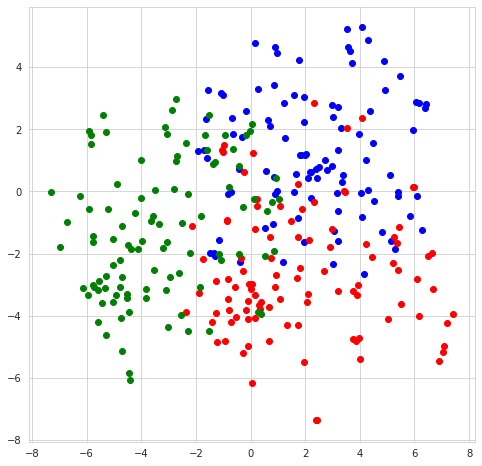

In [0]:
from sklearn.manifold import TSNE

def display_closestwords_tsnescatterplot(model, word, size, color):
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, topn = 100)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords, color = color)
    #for label, x, y in zip(word_labels, x_coords, y_coords):
        #plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    #plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    #plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    
display_closestwords_tsnescatterplot(model, 'машина', 50, 'blue')
display_closestwords_tsnescatterplot(model, 'химия', 50, 'red')
display_closestwords_tsnescatterplot(model, 'султан', 50, 'green')

plt.show()

## Часть 3

### Классификация категории товара

В этом задании Вам предстоит поучастовать в конкурсе от Авито: https://www.kaggle.com/c/texts-classification-ml-hse-2019/leaderboard

Задача конкурса - по заголовку объявления и текстовому описанию классифицировать объявление.

#### Задание 3.0

Загрузите train.csv и test.csv наборы данных

In [0]:
!wget -O train.zip https://www.dropbox.com/s/b5p7594y0sn079f/train.csv.zip?dl=0
!unzip train.zip
!pip3 install pymorphy2

--2019-12-27 22:36:59--  https://www.dropbox.com/s/b5p7594y0sn079f/train.csv.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/b5p7594y0sn079f/train.csv.zip [following]
--2019-12-27 22:36:59--  https://www.dropbox.com/s/raw/b5p7594y0sn079f/train.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb33f8d13af4a49929ee78f56e5.dl.dropboxusercontent.com/cd/0/inline/AvBLriPhj90-SDxxuLjdXs7ujOZ4KskjYYm2Mhs9grWSadoyqfbCXHsN6Tra0__9cD-kkok1rNIPgEMmJaPGPYygFdhAN9Krs2x1G85X3n1G3xvVS_SgZdsuU2F2nnqjMgU/file# [following]
--2019-12-27 22:36:59--  https://ucb33f8d13af4a49929ee78f56e5.dl.dropboxusercontent.com/cd/0/inline/AvBLriPhj90-SDxxuLjdXs7ujOZ4KskjYYm2Mhs9grWSadoyqfbCXHsN6Tra0__9cD-kkok1rNIPgEMmJaPGPYygFdhAN9Krs2x1G85X3n

In [0]:
train = pd.read_csv('train.csv')
train['title&description'] = train['title'].str[:] + ' ' + train['description'].str[:]
train = train.iloc[:5000]

#### Задание 3.1 [3 балла]


Проведите лемматизацию текстов (для этого Вам может понадобиться пакет pymorphy2: https://pymorphy2.readthedocs.io/en/latest/user/guide.html#id3)

In [0]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
train['title&description'] = train['title&description'].apply(lambda x: [morph.parse(ix)[0].normal_form for ix in x.split(' ')])

#### Задание 3.2 [3 балла]

Удалите "стоп-слова" (предлоги, междометия, ...). Поясните, как именно Вы выбирали стоп-слова

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))
train['title&description'] = train['title&description'].apply(lambda x: [ix for ix in x if ix not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Задание 3.3 [6 баллов]

Осуществите Tf-Idf преобразование текстов

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X, y = train[['title&description']], train['Category']
X['title&description'] = X['title&description'].apply(lambda x: ' '.join(x))

vectorizer.fit(X['title&description'])
X_tfidf = vectorizer.transform(X['title&description'])

Разбейте данные на обучение и валидацию

In [0]:
# tr_idx - индексы объектов из train, на которых будем обучать модель
# val_idx - индексы объектов из train, на которых будем тестировать обученную модель
np.random.seed(10) # не меняем seed!
tr_idx, val_idx = np.split(
    np.random.permutation(np.arange(len(X))), [int(np.floor(len(X)*0.7))]
)
tr = X_tfidf[tr_idx]; tr_target = y[tr_idx]
val = X_tfidf[val_idx]; val_target = y[val_idx]

Обучите логистическую регрессию на объектах с индексами tr_idx, которую Вы написали в Части 1. В качестве матрицы объект-признак возьмите TfIdf-матрицу, полученную вначале задания 3.3

In [0]:
w_init = np.random.rand(tr.shape[1])
w_init = np.expand_dims(w_init, axis = 1)
lr = LogReg(lambda_2=1.0, gd_type = 'stochastic', batch_size=30, tolerance=0.0001, max_iter = 20, w0 = w_init, alpha = 0.001, verbose = False)
lr.fit(tr, tr_target)

Посчитайте качество полученной модели на отложенной части (на объектах с индексами val_idx). В качестве метрики возьмите ту, которая используется в конкурсе

In [0]:
accuracy_score(lr.predict_proba(val), val_target)

Теперь обучите логистическую регрессию из sklearn и сравните качество, с Вашей реализацией

In [0]:
lr = LogisticRegression()
lr.fit(tr, tr_target)
accuracy_score(lr.predict(val), val_target)

0.57

#### Задание 3.4 [6 баллов]

Теперь попробуйте обучить логистическую регрессию (из sklearn), но где в качестве признакового описания текста возьмите не матрицу TfIfd, а средневзвешенное Word2Vec описание текста, то есть, для каждого слова из текста вычисляем его Word2Vec эмбеддинг и суммируем эти вектора с некоторыми весами. В качестве весом можно взять значения idf значение слова. Если какого-то слова нет в вашем словаре Word2Vec, то его можно заменить нулевым вектором, или вектором средних из всех Word2Vec векторов.

In [0]:
X_ = X['title&description'].apply(lambda x: sum([model[word] for word in x if word in model.wv.vocab]))

X_word2vec = np.empty((X.shape[0], 50))
for i in range(X.shape[0]):
  X_word2vec[i] = X_[i]

tr = X_word2vec[tr_idx]; tr_target = y[tr_idx]
val = X_word2vec[val_idx]; val_target = y[val_idx]

Посчитайте качество данной модели на отложенной выборке (выборке с индексами val_idx)

In [0]:
# Ваш код здесь:
lr.fit(tr, tr_target)
accuracy_score(lr.predict(val), val_target)

0.232

#### Задание 3.5 [бонус] [10 баллов]

Постарайтесь получить качество на лидерборде выше, чем у baseline решения (0.84726). В данном пункте Вы не ограничены ни моделями, которые можно применять, ни признаками, и даже можно каким-то образом обогащать данные. (Например: можно распрарсить Авито, найти объявления, которые в тесте и взять оттуда истинный класс)

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

tr = X_tfidf[tr_idx]; tr_target = y[tr_idx]
val = X_tfidf[val_idx]; val_target = y[val_idx]

gb = LGBMClassifier(silent=False)
gb.fit(tr, tr_target)
print(accuracy_score(gb.predict(val), val_target))

gb = GradientBoostingClassifier()
gb.fit(tr, tr_target)
print(accuracy_score(gb.predict(val), val_target))

0.6093333333333333
0.6306666666666667
